In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
from scipy import fft
from numpy import exp,sin,cos,pi
from numpy.linalg import norm
from pyquaternion import Quaternion 
from scipy.optimize import minimize

from utils import *
import time
#mean squared error: 0.00302
#params=np.array([\
# 1.00019169, 1.00485457, 0.98089897,\
# 0.00173489, 0.03556878, 0.19213672,\
# 0.99867178, 0.00847006, 0.02213006, 0.12979466]

#msqerr: 0.0029
#[ 1.0003588   1.00501068  0.98071385  0.00298074  0.0019567   0.20618256
#  1.03816403 -0.02316948 -0.01194352  0.12074971]

#msqerr: 0.0016
#[ 1.00019457  1.00488652  0.98081785  0.00157861  0.03279509  0.19761574
#  0.99666972  0.00134338  0.0370082  -0.02798724]

In [2]:
#Read in the raw data
raw_dat=load_endaq_log("data/accel_cal_")

#Pull out the magnetometer data in numpy form
dfMag=raw_dat['mag']
mag=dfMag.to_numpy()
# Get the magnetometer time series in seconds
ts=dfMag.index.to_numpy(dtype=np.float32)/1e9
ts=ts-ts[0]

# Synch the gyro to the magnetometer, convert to radians/s, subtract gyro bias
gyro=(pi/180)*synchronize_series(raw_dat['gyro'],ref=dfMag).to_numpy()
gyro-=np.asarray(len(ts)*[[-0.00021945402222017595, -0.00047822533118326656,-0.0006633888770801933]])

#Sync the accelerometer to the gyro
#the 8g accelerometer is by far the best.
acc=   synchronize_series(raw_dat['acc8'],ref=dfMag).to_numpy()


Successfully loaded  Ch80_8g_DC_Acceleration.csv
Successfully loaded  Ch32_16g_DC_Acceleration.csv
Successfully loaded  Ch43_IMU_Acceleration.csv
Successfully loaded  Ch47_Rotation.csv
Successfully loaded  Ch51_IMU_Magnetic_Field.csv


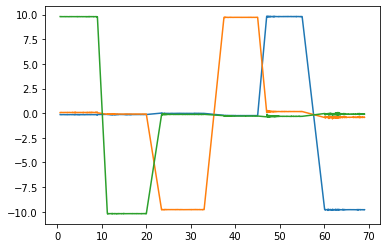

In [3]:
## Find the intervals where the sensor is stationary
intervals=[\
          (0.6,9),\
          (11.2,20),\
          (23.4,33),\
          (37.4,45),\
          (47,55),\
          (60,69),\
          ]       


ts_0,acc_0=idx_filter(ts,acc,intervals)
plt.plot(ts_0,acc_0)

In [4]:
params=[ 1.00019457,  1.00488652,  0.98081785,  \
        0.00157861,  0.03279509,   0.19761574,  \
        0.99666972,  0.00134338,  0.0370082 , -0.02798724]

In [5]:
#params=[scale0,scale1,scale2,bias1,bias2,bias3,qw,qx,qy,qz]

#Initial guess
#params=np.array([\
#    1.0,1.0,1.0,\
#    0.0,0.0,0.0,\
#    1.0,0.0,0.0,0.0 \
#    ])

#ACC 8
#([ 1.00019457,  1.00488652,  0.98081785,  0.00157861,  0.03279509,
#        0.19761574,  0.99666972,  0.00134338,  0.0370082 , -0.02798724])

#ACC16
#([ 0.99947972,  0.9985753 ,  1.0101357 ,  0.163847  ,  0.57478074,
#        0.44491193,  0.99663155,  0.00126076,  0.03802838, -0.02799045])

#ACCIMU

#Use the last best guess
params=[ 1.00019457,  1.00488652,  0.98081785,  \
        0.00157861,  0.03279509,   0.19761574,  \
        0.99666972,  0.00134338,  0.0370082 , -0.02798724]

print(msqError(params,intervals,acc,gyro,mag,ts))

##Allocate arrays once for speedup
#workspace={}
#num_samples=len(ts)
#workspace['acc_scratch']=np.zeros((num_samples,3))
#workspace['Q']=np.tile(np.array([1.0,0.0,0.0,0.0]),(num_samples,1))
#workspace['Q_quat']=np.tile(Quaternion(np.array([1.0,0.0,0.0,0.0])),(num_samples,1))
#workspace['acc_lab']=np.zeros((num_samples,3))
#func = lambda params: msqError(params,intervals,acc,gyro,mag,ts,workspace=workspace)


##Takes 223 seconds to compute with preallocation
## 209 seconds without preallocation
func = lambda params: msqError(params,intervals,acc,gyro,mag,ts)

tic=time.time()
sol=minimize(func,params)
toc=time.time()

print(f"Minimization took {toc-tic:0.1f} seconds")
print(sol)

0.0016876220140056336
Minimization took 595.5 seconds
      fun: 0.0016681719243430194
 hess_inv: array([[ 1.40432642e-02,  7.19152908e-04,  1.05891122e-03,
         8.19832255e-03, -6.08500540e-03,  1.78786621e-02,
        -5.42488626e-05, -7.57217437e-03, -3.44114291e-03,
        -8.44230123e-03],
       [ 7.19152908e-04,  1.46665730e-02, -2.41859468e-04,
         2.71668201e-03,  9.83339454e-03,  2.11312889e-03,
        -2.29540458e-03, -1.59625082e-02, -7.20417618e-03,
        -6.01235387e-03],
       [ 1.05891122e-03, -2.41859468e-04,  1.39231981e-02,
        -6.26976564e-03,  3.73534242e-03, -3.76931839e-03,
        -1.01718975e-03, -8.30755080e-03, -3.60040444e-03,
         5.19991431e-03],
       [ 8.19832255e-03,  2.71668201e-03, -6.26976564e-03,
         8.22286455e-01,  1.05134340e-01,  3.62474946e-02,
        -4.79398434e-02, -1.93537803e-01, -1.27314997e-01,
        -1.37173599e-01],
       [-6.08500540e-03,  9.83339454e-03,  3.73534242e-03,
         1.05134340e-01,  9.151

Text(0, 0.5, 'lab frame acceleration (m/s^2)')

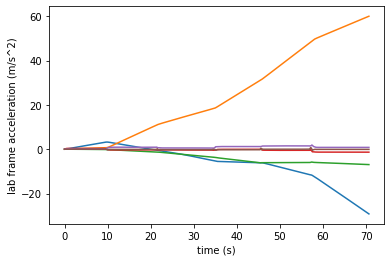

In [6]:
#x: array([ 9.99478512e-01,  9.98578742e-01,  1.01013295e+00,  1.63830757e-01,
#5.74745265e-01,  4.44943789e-01,  9.96630435e-01,  7.49611632e-04,
#3.80836638e-02, -2.80097450e-02])
params=sol.x
q=np.array(params[6:])
q/=np.linalg.norm(q)
q0=Quaternion(q)

## Apply scale-bias calibration
acc_calibrated=calibrate(acc,params=params)
acc_1=calibrate(acc,params=params)
# Rotate into lab frame using initial orientation
for i in range(len(acc_calibrated)):
    acc_calibrated[i]=q0.rotate(acc_calibrated[i])

#plt.plot(ts,acc_calibrated)

# Use madgwick filter to estimate orientation, and integrate to find position estimate
ACC_LAB,QIMU,state=apply_ahrs(gyro,acc_calibrated,mag,ts,q0=q,g=[0,0,9.799],position=True,reset=True,filter="QMARG",betaval=0.6)
_,_,state2=apply_ahrs(gyro,acc_calibrated,mag,ts,q0=q,g=[0,0,9.799],position=True,reset=False)

#Plot the quiet parts of the calibration data
ts_0,ACC_LAB0=idx_filter(ts,ACC_LAB,intervals)
plt.plot(ts,state)
plt.xlabel("time (s)")
plt.ylabel("lab frame acceleration (m/s^2)")

[(0.6, 9), (11.2, 20), (23.4, 33), (37.4, 45), (47, 55), (60, 69)]
Mean : -0.13317080921630833 Variance : 0.006312980370733175
Mean : -0.04689795818743465 Variance : 0.05010973542687542
Mean : 0.0012944508884026012 Variance : 0.009910743373109014
Mean : 7.147358527629763e-20 Variance : 9.774087984743668e-05
Mean : 7.147358527629763e-20 Variance : 4.044785591771656e-05
Mean : 5.956132106358136e-20 Variance : 8.900485060585024e-06


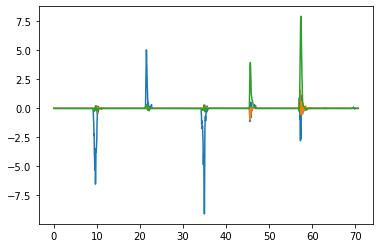

In [7]:
#Sensor Variances

def variance_on_intervals(data,times,intervals,ax=0):
    """
    compute the variance of data (along axis0) subject to the idx filter
    data: time series of data n x m array
    times: time stamps of the data, nx1 array
    intervals: list of tuples defining the time intervals
    
    """
    tunion=[]
    mask=np.array([False]*len(times))
    for interval in intervals:
        mask|= (interval[0]<times) & (times<interval[1])    
    print(f"Mean : {np.mean(data[mask,ax],axis=0)} Variance : {np.var(data[mask,ax],axis=0)}")

I1=[\
      (0.6,9),\
      (11.2,20),\
      (23.4,33),\
      (37.4,45),\
   ]    
I2=[\
      (0.6,9),\
      (11.2,20),\
      (47,55),\
      (60,69),\
   ]   
I3=[\
      (23.4,33),\
      (37.4,45),\
      (47,55),\
      (60,69),\
   ]   

plt.plot(ts,gyro)
IG=[\
    (0,8),\
    (10.3,20),\
    (24,32),\
    (38,44),\
    (48.3,55),\
    (61,69)\
    
]
variance_on_intervals(acc_1,ts,I1,0)
variance_on_intervals(acc_1,ts,I2,1)
variance_on_intervals(acc_1,ts,I3,2)

variance_on_intervals(gyro,ts,IG,0)
variance_on_intervals(gyro,ts,IG,1)
variance_on_intervals(gyro,ts,IG,2)

# Variances

## 8g Accelerometer
#### Before Calibration
X Mean -0.02610191344605809 Variance 3.794052231620003e-05 <br>
Y Mean -0.14359739161124122 Variance 0.08477044021011895 <br>
Z Mean -0.12716825053941908 Variance 6.334849766450069e-05 <br>
Ver-2<br>
X Mean : -0.13466998199421296 Variance : 0.006311554766699753 <br>
Y Mean : -0.07818062564551803 Variance : 0.04961562740185837<br>
Z Mean : -0.20179519886845168 Variance : 0.010302413159749885<br>
Ver-3<br>
##### No Change<br>
 
#### Post Calibration
X Mean -0.024528382048952718 Variance 3.7955287928639906e-05 <br>
Y Mean -0.11150399308928384 Variance 0.08560092921846203 <br>
Z Mean 0.072886849515987 Variance 6.0941486316839465e-05 <br>
Ver-2<br>
X Mean : -0.1331175746879974 Variance : 0.006314011084269695<br>
Y Mean : -0.0457675668074582 Variance : 0.0501017076097369<br>
Z Mean : -0.0003085935156853141 Variance : 0.009910959119037744<br>
Ver-3<br>
X Mean : -0.13317080921630833 Variance : 0.006312980370733175<br>
Y Mean : -0.04689795818743465 Variance : 0.05010973542687542<br>
Z Mean : 0.0012944508884026012 Variance : 0.009910743373109014<br>


## 16g Accelerometer
#### Before Calibration
X Mean -0.14096203041908714 Variance 0.001426752407185179 <br>
Y Mean -0.702818565025761 Variance 0.13787802246844177 <br>
Z Mean -0.5921365742240664 Variance 0.008469381518042525 <br>
Ver-2 <br>
X Mean : -0.2586534399780092 Variance : 0.015067023035566118<br>
Y Mean : -0.630796970281723 Variance : 0.08259990077565804<br>
Z Mean : -0.503442812331781 Variance : 0.01835876620967424<br>
Ver-3<br>
##### No Change<br>
 
#### Post Calibration
X Mean 0.022958312096298922 Variance 0.0014252681781532466 <br>
Y Mean -0.12703652302255156 Variance 0.13748543301538543 <br>
Z Mean -0.15322636398952388 Variance 0.008641937787339656 <br>
Ver-2<br>
X Mean : -0.2571251561778257 Variance : 0.015072886787309774<br>
Y Mean : -0.6010842822929439 Variance : 0.08340912523678415<br>
Z Mean : -0.296169956789211 Variance : 0.017661200192768768<br>
Ver-3<br>
X Mean : -0.09468779832648504 Variance : 0.015051312588610807<br>
Y Mean : -0.05515518064342762 Variance : 0.08236527614067521<br>
Z Mean : -0.06360038631798157 Variance : 0.01873270830189788<br>

## Gyroscope
X Mean 0.00019973657042901357 Variance 3.418428007189658e-07 <br>
Y Mean -0.0002800227426850185 Variance 3.418428007189658e-07 <br>
Z Mean -0.0005012996277434066 Variance 3.418428007189658e-07 <br>
Ver-2 <br>
X Mean : -0.00021945402222017595 Variance : 9.774087984743668e-05<br>
Y Mean : -0.00047822533118326656 Variance : 4.044785591771656e-05<br>
Z Mean : -0.0006633888770801933 Variance : 8.900485060585024e-06<br>
Ver-3 <br>
X Mean : 7.147358527629763e-20 Variance : 9.774087984743668e-05<br>
Y Mean : 7.147358527629763e-20 Variance : 4.044785591771656e-05<br>
Z Mean : 5.956132106358136e-20 Variance : 8.900485060585024e-06<br>
<br>
<br>
Key: <br>
Ver-1 Initial code with single interval<br>
Ver-2 Cleaned up code with all intervals<br>
Ver-3 Gyroscope corrections<br><br>
Angular velocity of the Earth - 0.00007272205 <br>
Is smaller then the mean of any axis by atleast an order of magnitude, thus unlikely to be resolved

[(0.6, 9), (11.2, 20), (23.4, 33), (37.4, 45), (47, 55), (60, 69)]


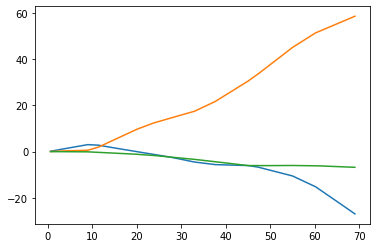

In [8]:
## Inspect the dead-reckoning position estimate
print(intervals)
ts_masked,state_masked=idx_filter(ts,state,intervals)
plt.plot(ts_masked,state_masked[:,0])
plt.plot(ts_masked,state_masked[:,1])
plt.plot(ts_masked,state_masked[:,2])

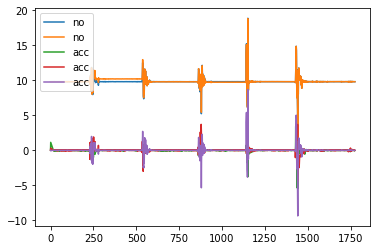

In [9]:
#Compare the uncalibrated vs calibrated acceleration magnitudes
plt.plot(np.sum(acc_calibrated**2,axis=1)**0.5  ,label="no")
plt.plot(np.sum(acc**2,axis=1  )**0.5,label="no")
plt.plot(ACC_LAB,label="acc")
plt.legend()

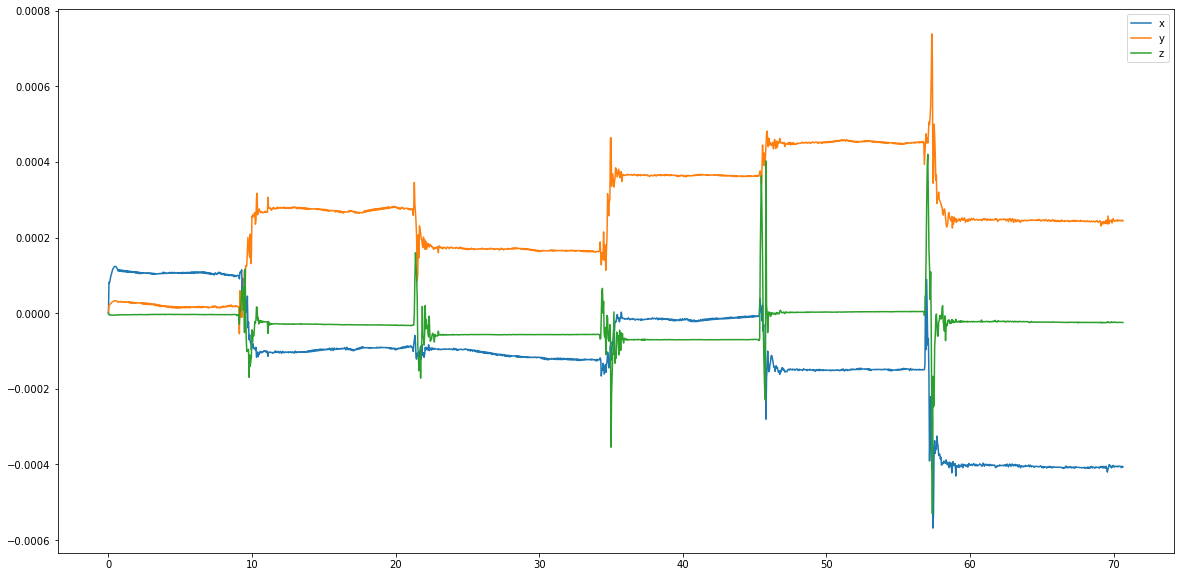

In [48]:
#Kalman Filter
dt=np.mean(ts[1:]-ts[0:-1])


#Kalman corrected state vector, accuracy matrix, and Kalman gain as arrays
#Velocity will be used everywhere as is from the state vector since we aren't measuring it

state_guess = len(ts)*[[0,0,0,0,0,0]]
P=len(ts)*[np.matrix(np.diag([0,0,0,0,0,0]))] 
K=[np.matrix(np.diag([0,0,0,0,0,0]))]
#Fake GPS data
z=len(ts)*[[0,0,0,0,0,0]]


#F is old state to new state Matrix, B is acceleration to new state Matrix

F=np.matrix(\
[\
[1,  0,  0,  dt,  0,  0  ] ,\
[0,  1,  0,  0,  dt,  0  ] ,\
[0,  0,  1,  0,  0,  dt  ] ,\
[0,  0,  0,  1,  0,  0   ] ,\
[0,  0,  0,  0,  1,  0   ] ,\
[0,  0,  0,  0,  0,  1   ] ,\
]\
)
B=np.matrix(\
[\
[dt**2/2,  0,    0    ] ,\
[0,    dt**2/2,  0    ] ,\
[0,        0,  dt**2/2] ,\
[dt,       0,    0    ] ,\
[0,       dt,    0    ] ,\
[0,        0,    dt   ] ,\
]\
)

#Q covariance of sensor axes matrix, R Covariance of GPS uncertainty Matrix

#Acceleration Variance Vector
acc_var=[-0.13317, -0.04689, 0.00129]
#Noise in state equation is B times noise in acceleration
#Use sum of variance relation to obtain
q=[]
r=6*[0.00001]
for i in range(6):
    q.append(B.item((i,0))*acc_var[0]+B.item((i,1))*acc_var[1]+B.item((i,2))*acc_var[2])

    
q=6*[0.0001]
Q,R = np.matrix(np.diag(q)),np.matrix(np.diag(r))

#Initialise variables 

for i in range(len(ts)):
    z[i]=[z[i][0],z[i][1],z[i][2],0,0,0]
#    state_guess[i]=[state_guess[i][0],state_guess[i][1],state_guess[i][2],state[i][3],state[i][4],state[i][5]]

#create naive state guess and naive accuracy matrix
state_naive,P_naive = state_guess[0],P[0]
ACC_L=np.asarray(len(ts)*[[0,0,0]])
#Kalman filter loop
for i in range(1,len(ts)):
    #Predict Equations
    state_naive=(np.asarray(F.dot(state_guess[i-1]))+np.asarray(B.dot(ACC_LAB[i].tolist()))).tolist()[0]
    P_naive = F.dot(P[i-1])
    P_naive = P_naive.dot(F.transpose())+Q
    if i>1:
        for j in [3,4,5]:
            z[i][j]=state_guess[i-1][j]
    #Update Equations
    K=P_naive.dot(np.linalg.inv(P_naive+R))
    y=np.asarray(z[i])-np.asarray(state_naive)
    state_guess[i]=(np.asarray(state_naive)+np.asarray(K.dot(y).tolist()[0])).tolist()
    P[i]=(np.matrix(np.identity(6))-K).dot(P_naive)
    #print(" ")
    #print(f"Z : {z[i]}")
    #print(f"State Guess : {state_guess[i]}")
    #print(f"Difference : {np.asarray(z[i])-np.asarray(state_guess[i])}")
    #print(f"K*y : {K.dot(y).tolist()[0]}")
    #print(f"Y is : {y}")
    #print(f"K is : {K}")
    #print(" ")
    

plt.figure(figsize=(20,10))
#plt.plot(ts,state_guess, label="guess")
plt.plot(ts,np.asarray(state_guess)[:,0],label="x")
plt.plot(ts,np.asarray(state_guess)[:,1],label="y")
plt.plot(ts,np.asarray(state_guess)[:,2],label="z")

#plt.plot(ts,state, label ="ax")

plt.legend()
    

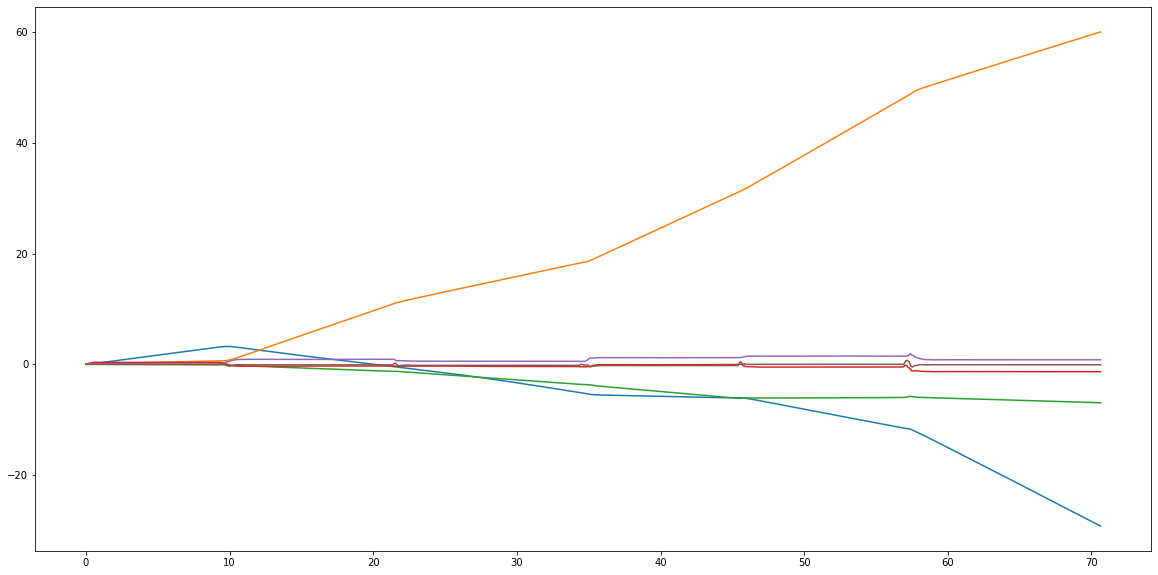

In [12]:
plt.figure(figsize=(20,10))
plt.plot(ts,state)